In [114]:
# import libraries
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

In [115]:
# read dataset 
#!kaggle competitions download -c nlp-getting-started --force
#!unzip nlp-getting-started.zip
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train Data Shape = {}'.format(train.shape))
print('Train Data Memory Usage = {:.2f}'.format(train.memory_usage().sum()/1024**2))
print('Test Data Shape = {}'.format(test.shape))
print('Test Data Memory Usage = {:.2f}'.format(test.memory_usage().sum()/1024**2))

Train Data Shape = (7613, 5)
Train Data Memory Usage = 0.29
Test Data Shape = (3263, 4)
Test Data Memory Usage = 0.10


# **1. Keyword and Location**
## **Missing Values**
Both train and test set have the same ratio of missing values in keyword and location 
* 0.8% of `keyword` is missing in both train and test set
* 33% of `location` is missing in both train and test set

Both missing values for train and test set is very close hence we can conclude that they are sampled from the same dataset. Missing values are filled with `nokeyword` and `nolocation` respectively.

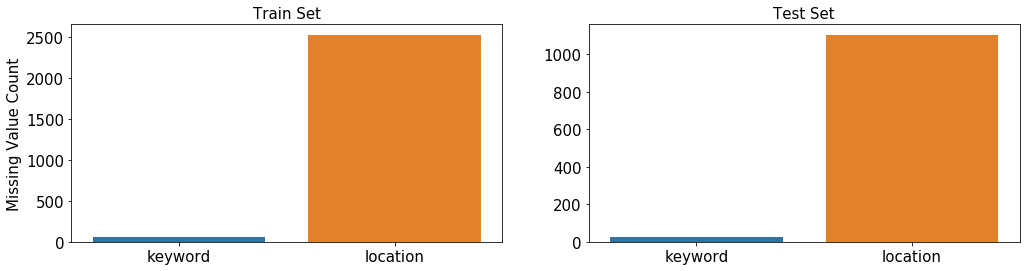

In [118]:
# ratio of missing values 
missing = ['keyword', 'location']
_, axes = plt.subplots(1,2,figsize=(17,4))
sns.barplot(x=train[missing].isna().sum().index, y=train[missing].isna().sum().values, ax=axes[0])
sns.barplot(x=test[missing].isna().sum().index, y=test[missing].isna().sum().values, ax=axes[1])
axes[0].set_ylabel('Missing Value Count',size=15)
axes[0].set_title('Train Set',fontsize=15)
axes[1].set_title('Test Set',fontsize=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
for df in [train,test]:
    for col in missing:
        df[col].fillna(f'no{col}',inplace=True)

## **Cardinality and Target Distribution**
There are too many unique `location` since they are given by user inputs, hence it is not suitable to be used as a feature.

Fortunately, there is signal in` keyword` because some of those words can only be used in one context. Keywords have very different tweet counts and target means. `keyword `can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on `keyword`.

In [119]:
# number of unique keywords and locations 
print(f'Unique values of keyword for train = {train.keyword.nunique()} and test = {test.keyword.nunique()} ')
print(f'Uninque value of locations for train = {train.location.nunique()} and test = {test.location.nunique()}')

Unique values of keyword for train = 222 and test = 222 
Uninque value of locations for train = 3342 and test = 1603


Text(0.5, 1.0, 'Target Distribution in Keywords')

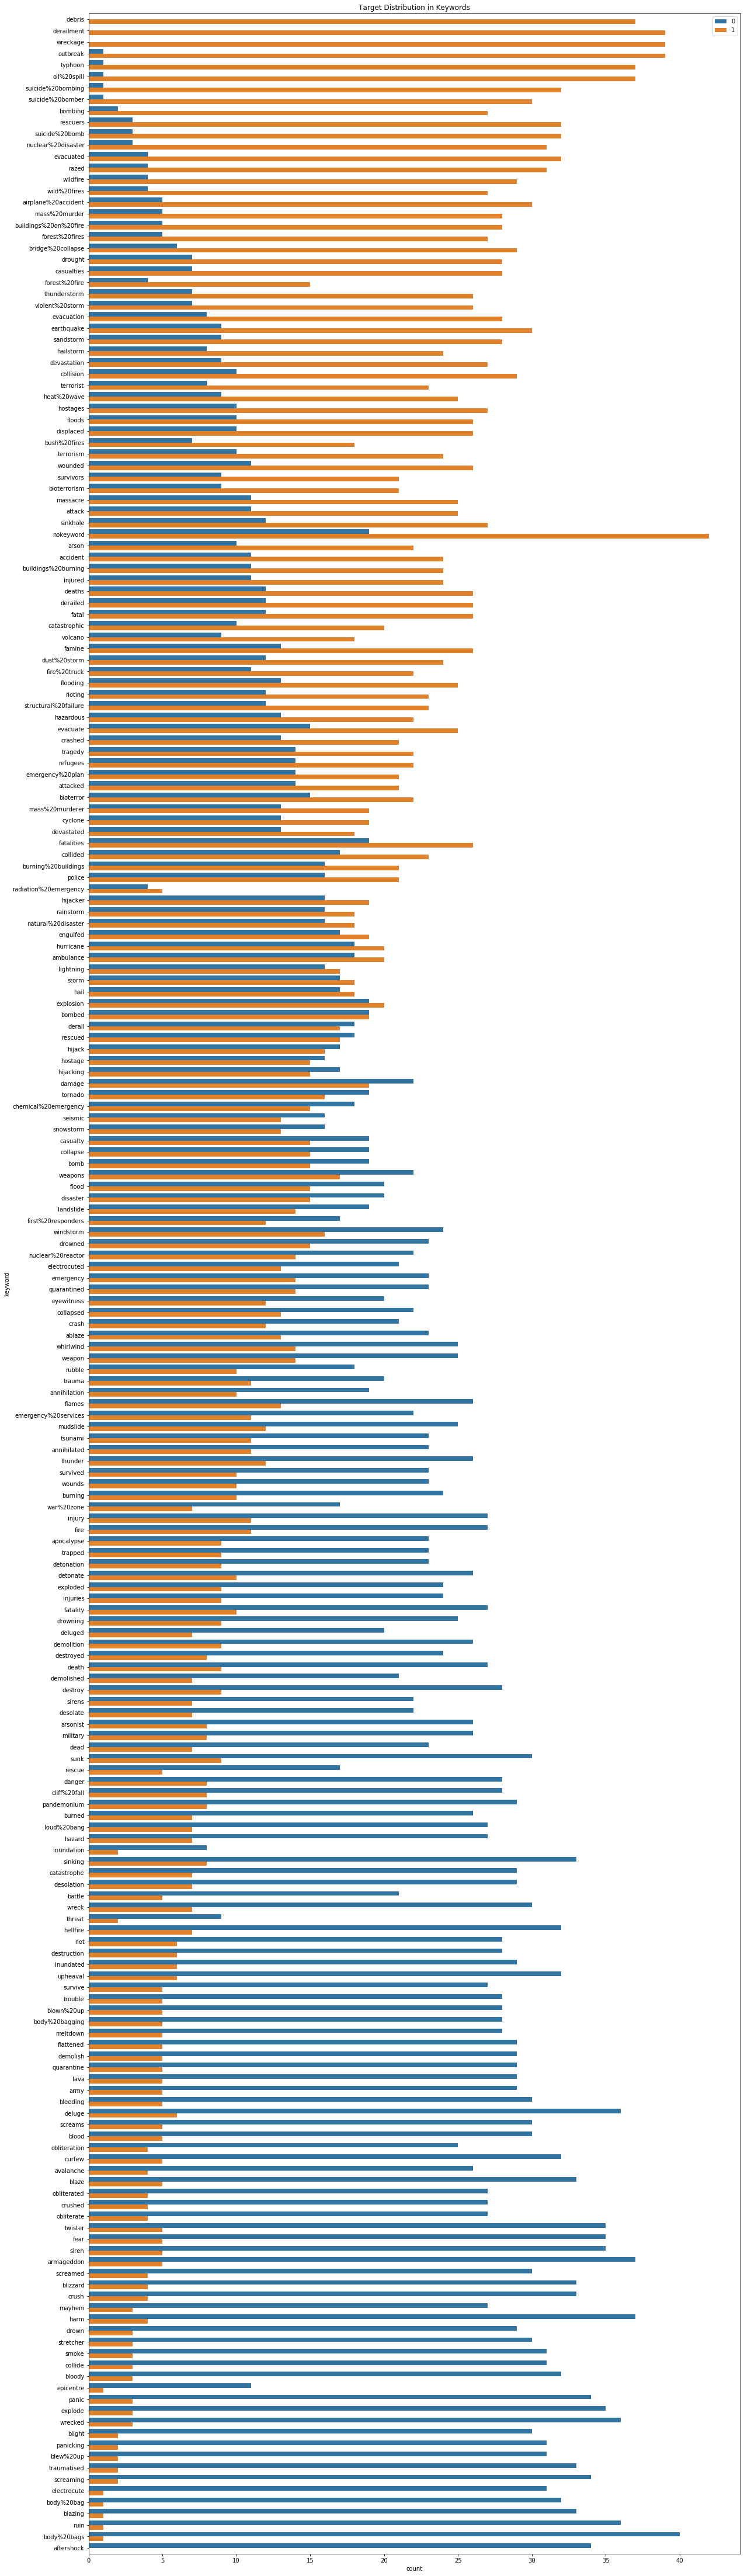

In [129]:
# plot the target distribution in keywords
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(20,80))
sns.countplot(y=train.sort_values(by='target_mean', ascending=False)['keyword'], hue=train.sort_values(by='target_mean', ascending=False)['target'])
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

# **Meta Features**
Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. Based on the dataset we have, it is observed that disaster tweets are often presented in a more formal and grammatically correct form since is coming from news agencies. Non-disaster tweets are often contain with internet slangs, short-from and typos as they are tweeted out by individual users. 

Below shows the meta features used in the analysis:
* `word_count` number of words
* `unique_word_count` number of unique words
* `stop_word_count` number of stop words
* `url_count` number of urls 
* `mean_word_length` mean of character count in words
* `char_count` number of characters
* `punctuation_count` number of punctuation
* `hastag_count` number of hashtag (#)
* `mention_count` number of mentions (@)

In [121]:
# number of words
train['word_count'] = train.text.apply(lambda x: len(str(x).split()))
test['word_count'] = test.text.apply(lambda x: len(str(x).split()))

# number of unique words
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
test['unique_word_count'] = test['text'].apply(lambda x: len(set(str(x).split())))

# number of stop words
train['stop_word_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test['stop_word_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# number of urls
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test['url_count'] = test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean of word length
train['mean_word_length'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_length'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#number of characters
train['char_count'] = train['text'].apply(lambda x: len(str(x)))
test['char_count'] = test['text'].apply(lambda x: len(str(x)))

#number of punctuations
train['punctuation_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
                                        
#number of hashtag
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test['hashtag_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

#number of mentions
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test['mention_count'] = test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

Both meta features from both dataset have very similar distributions which further proves that both train and test set are sampled from the same dataset.

All of the meta features have information about target as well, but some of them are not good enough such as `url_count`, `hashtag_count` and `mention_count`.

On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets.

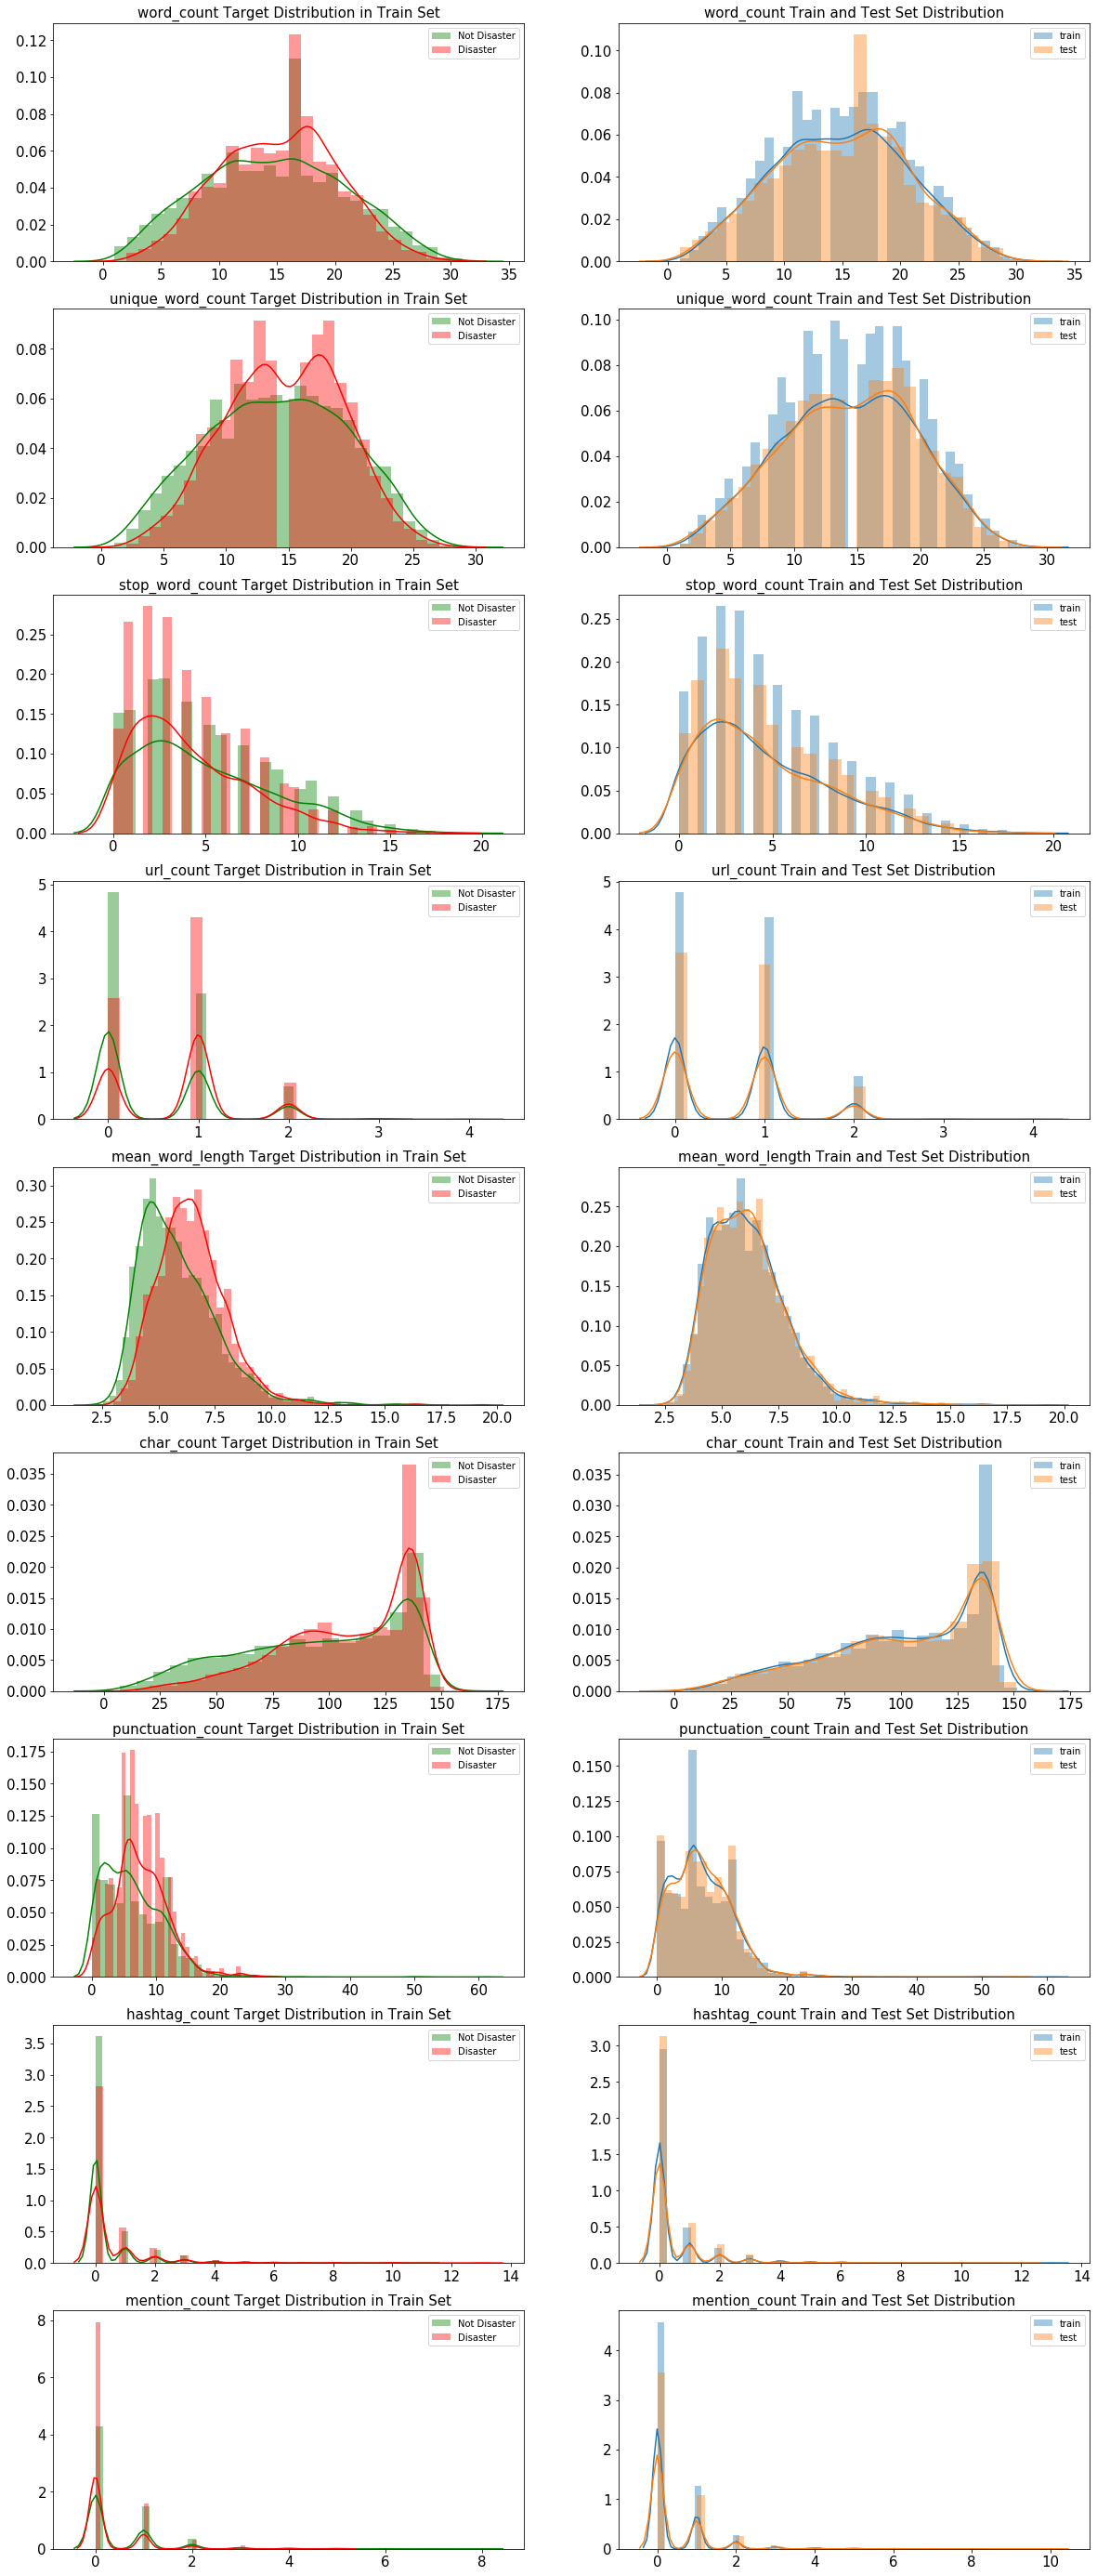

In [122]:
# plot the distrbution of meta features 
meta = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 
        'mean_word_length', 'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

DISASTER_TWEETS = train['target'] == 1

_, axes = plt.subplots(len(meta),2,figsize=(20,50))

for i, feat in enumerate(meta):
    sns.distplot(train.loc[~DISASTER_TWEETS][feat], label = 'Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train.loc[DISASTER_TWEETS][feat], label = 'Disaster', ax=axes[i][0], color='red')
    sns.distplot(train[feat], label='train', ax=axes[i][1])
    sns.distplot(test[feat], label='test', ax=axes[i][1])
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=15)
        axes[i][j].tick_params(axis='y', labelsize=15)
        axes[i][j].legend()
    axes[i][0].set_title(f'{feat} Target Distribution in Train Set',fontsize=15)
    axes[i][1].set_title(f'{feat} Train and Test Set Distribution', fontsize=15)

# **3.Target and N-grams**
## **Target**
Class distributions are 57% for 0 (Not Disaster) and 43% for 1 (Disaster). Classes are almost equally separated so they don't require any stratification by target in cross-validation.

In [123]:
# Target distribution 
is_disaster = int(np.round((train.groupby('target').count()['id'][1] / train.shape[0])*100))
not_disaster = int(np.round((train.groupby('target').count()['id'][0] / train.shape[0])*100))
print(f'{is_disaster}% of target is disaster')
print(f'{not_disaster}% of target is not disaster')

43% of target is disaster
57% of target is not disaster


Text(0.5, 1.0, 'Target Count in Training Set')

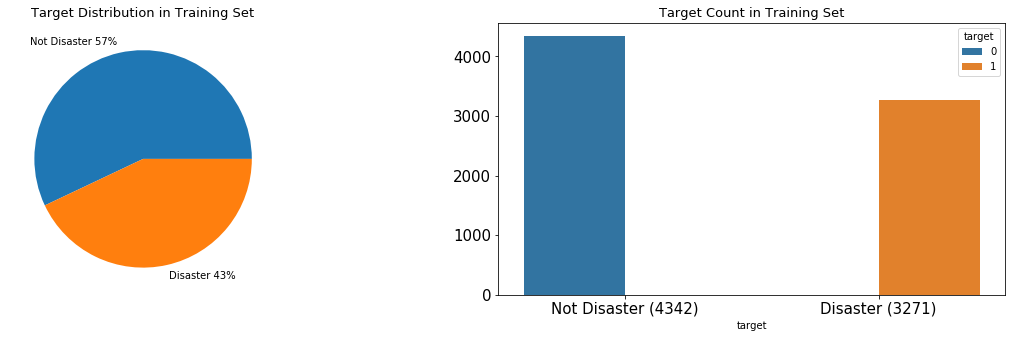

In [124]:
# plot in graph
_,axes = plt.subplots(1,2,figsize=(20,5))
train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=[f'Not Disaster {not_disaster}%',f'Disaster {is_disaster}%'])
sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

In [125]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
    
for tweet in train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

## **Unigrams**
Most common unigrams exist in both classes are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about `target`.

Text(0.5, 1.0, 'Top 100 most common unigrams in Non-disaster Tweets')

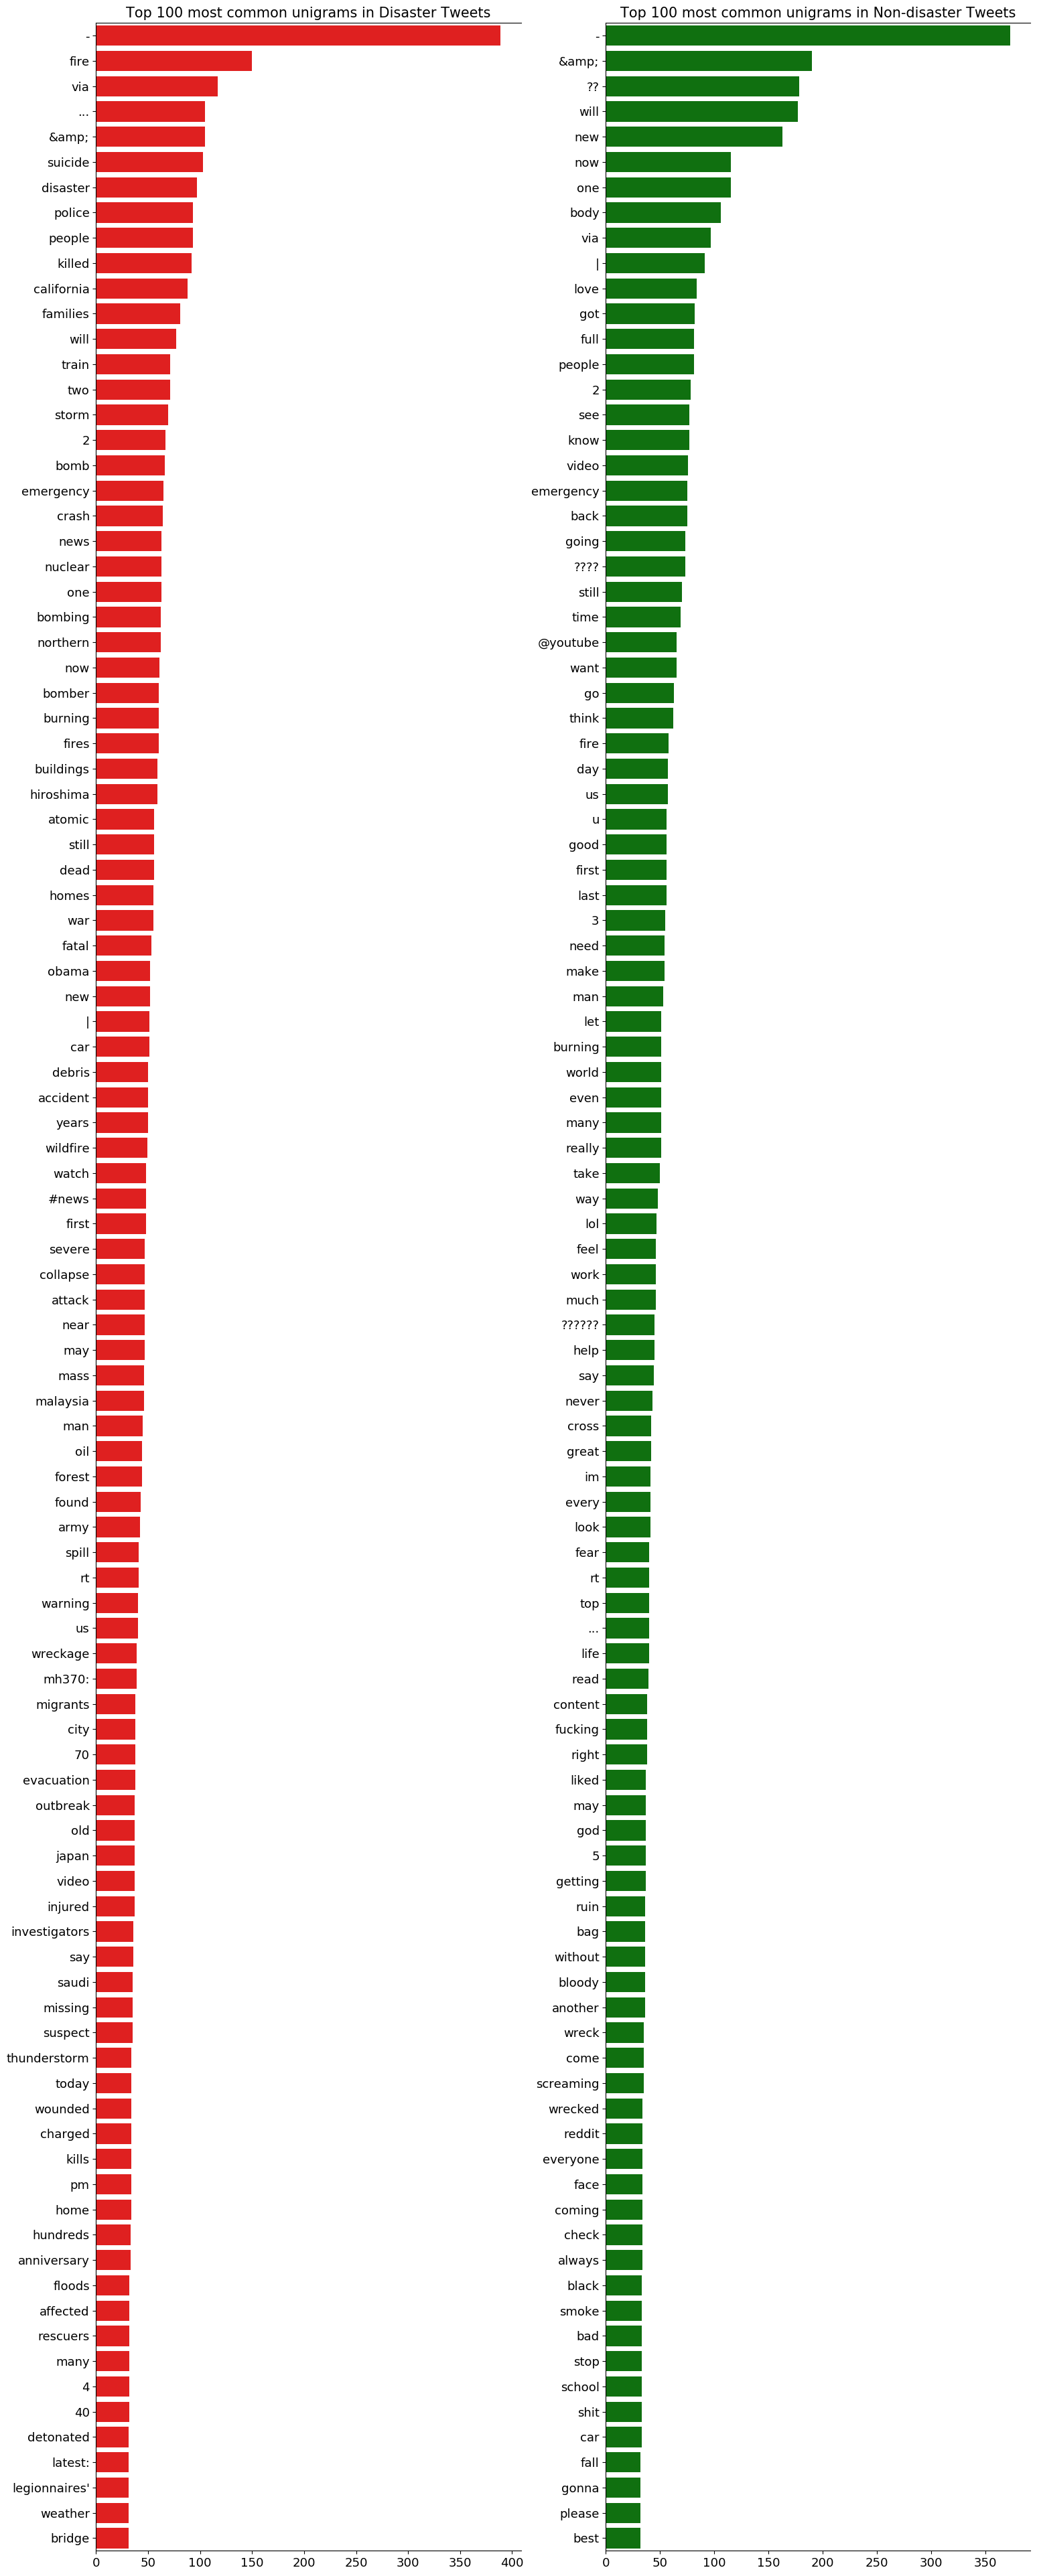

In [126]:
_, axes = plt.subplots(1,2, figsize=(18, 50), dpi=100)

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)


## **Bigrams**
There are no common bigrams exist in both classes since the context is clearer.

Text(0.5, 1.0, 'Top 100 most common bigrams in Non-disaster Tweets')

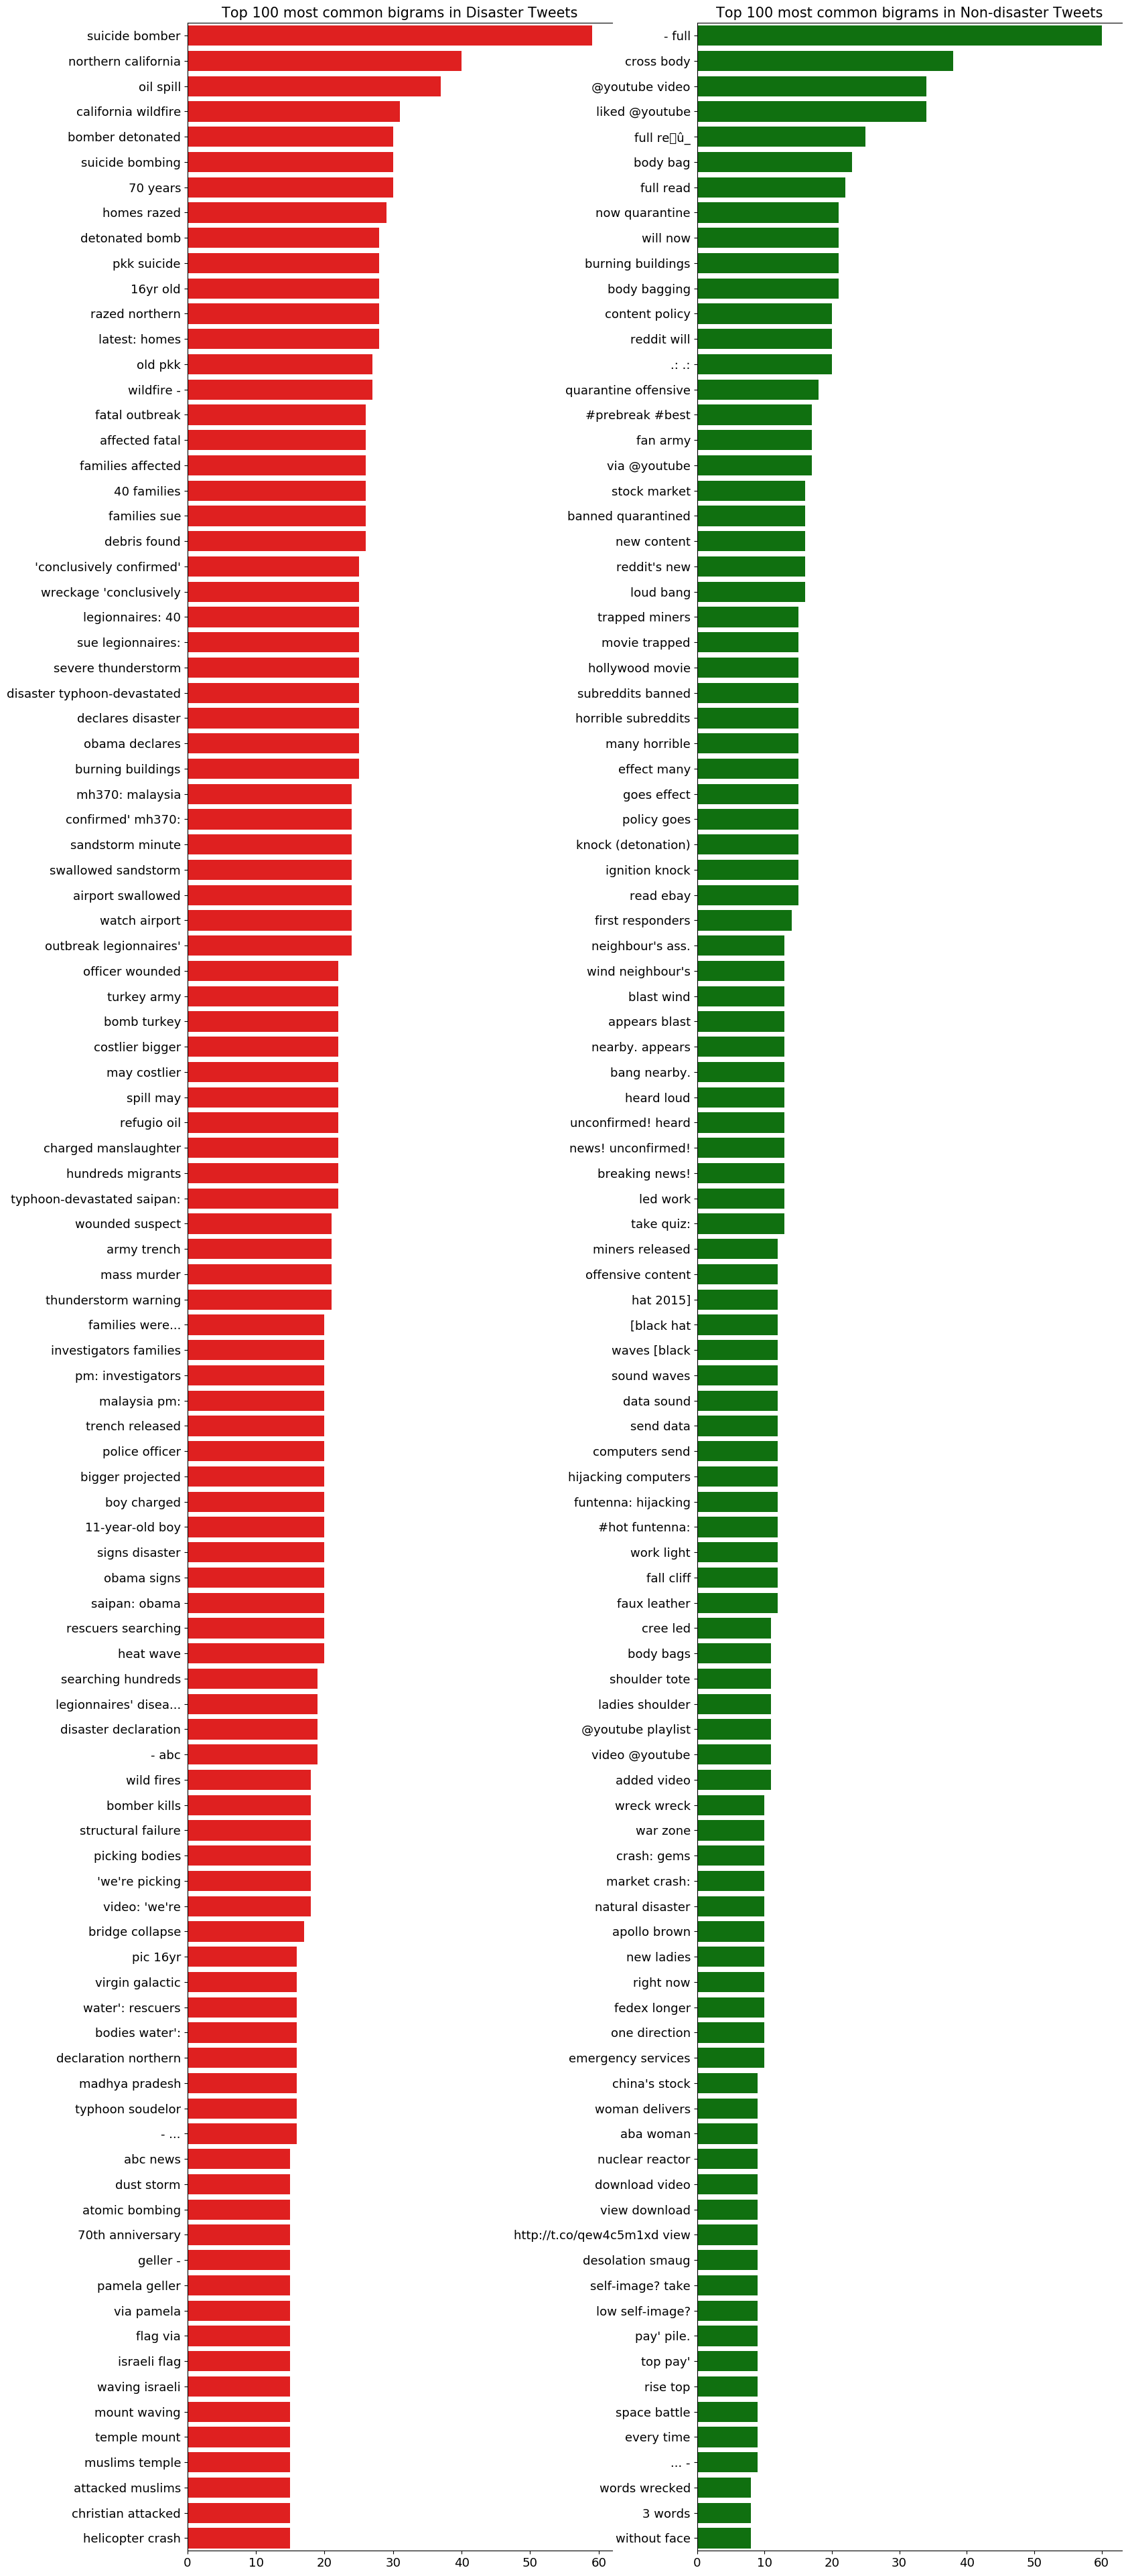

In [127]:
_, axes = plt.subplots(1,2, figsize=(18, 50), dpi=100)

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)


## **Trigrams**
There are no common trigrams exists in both classes because context is clearer.

Text(0.5, 1.0, 'Top 100 most common trigrams in Non-disaster Tweets')

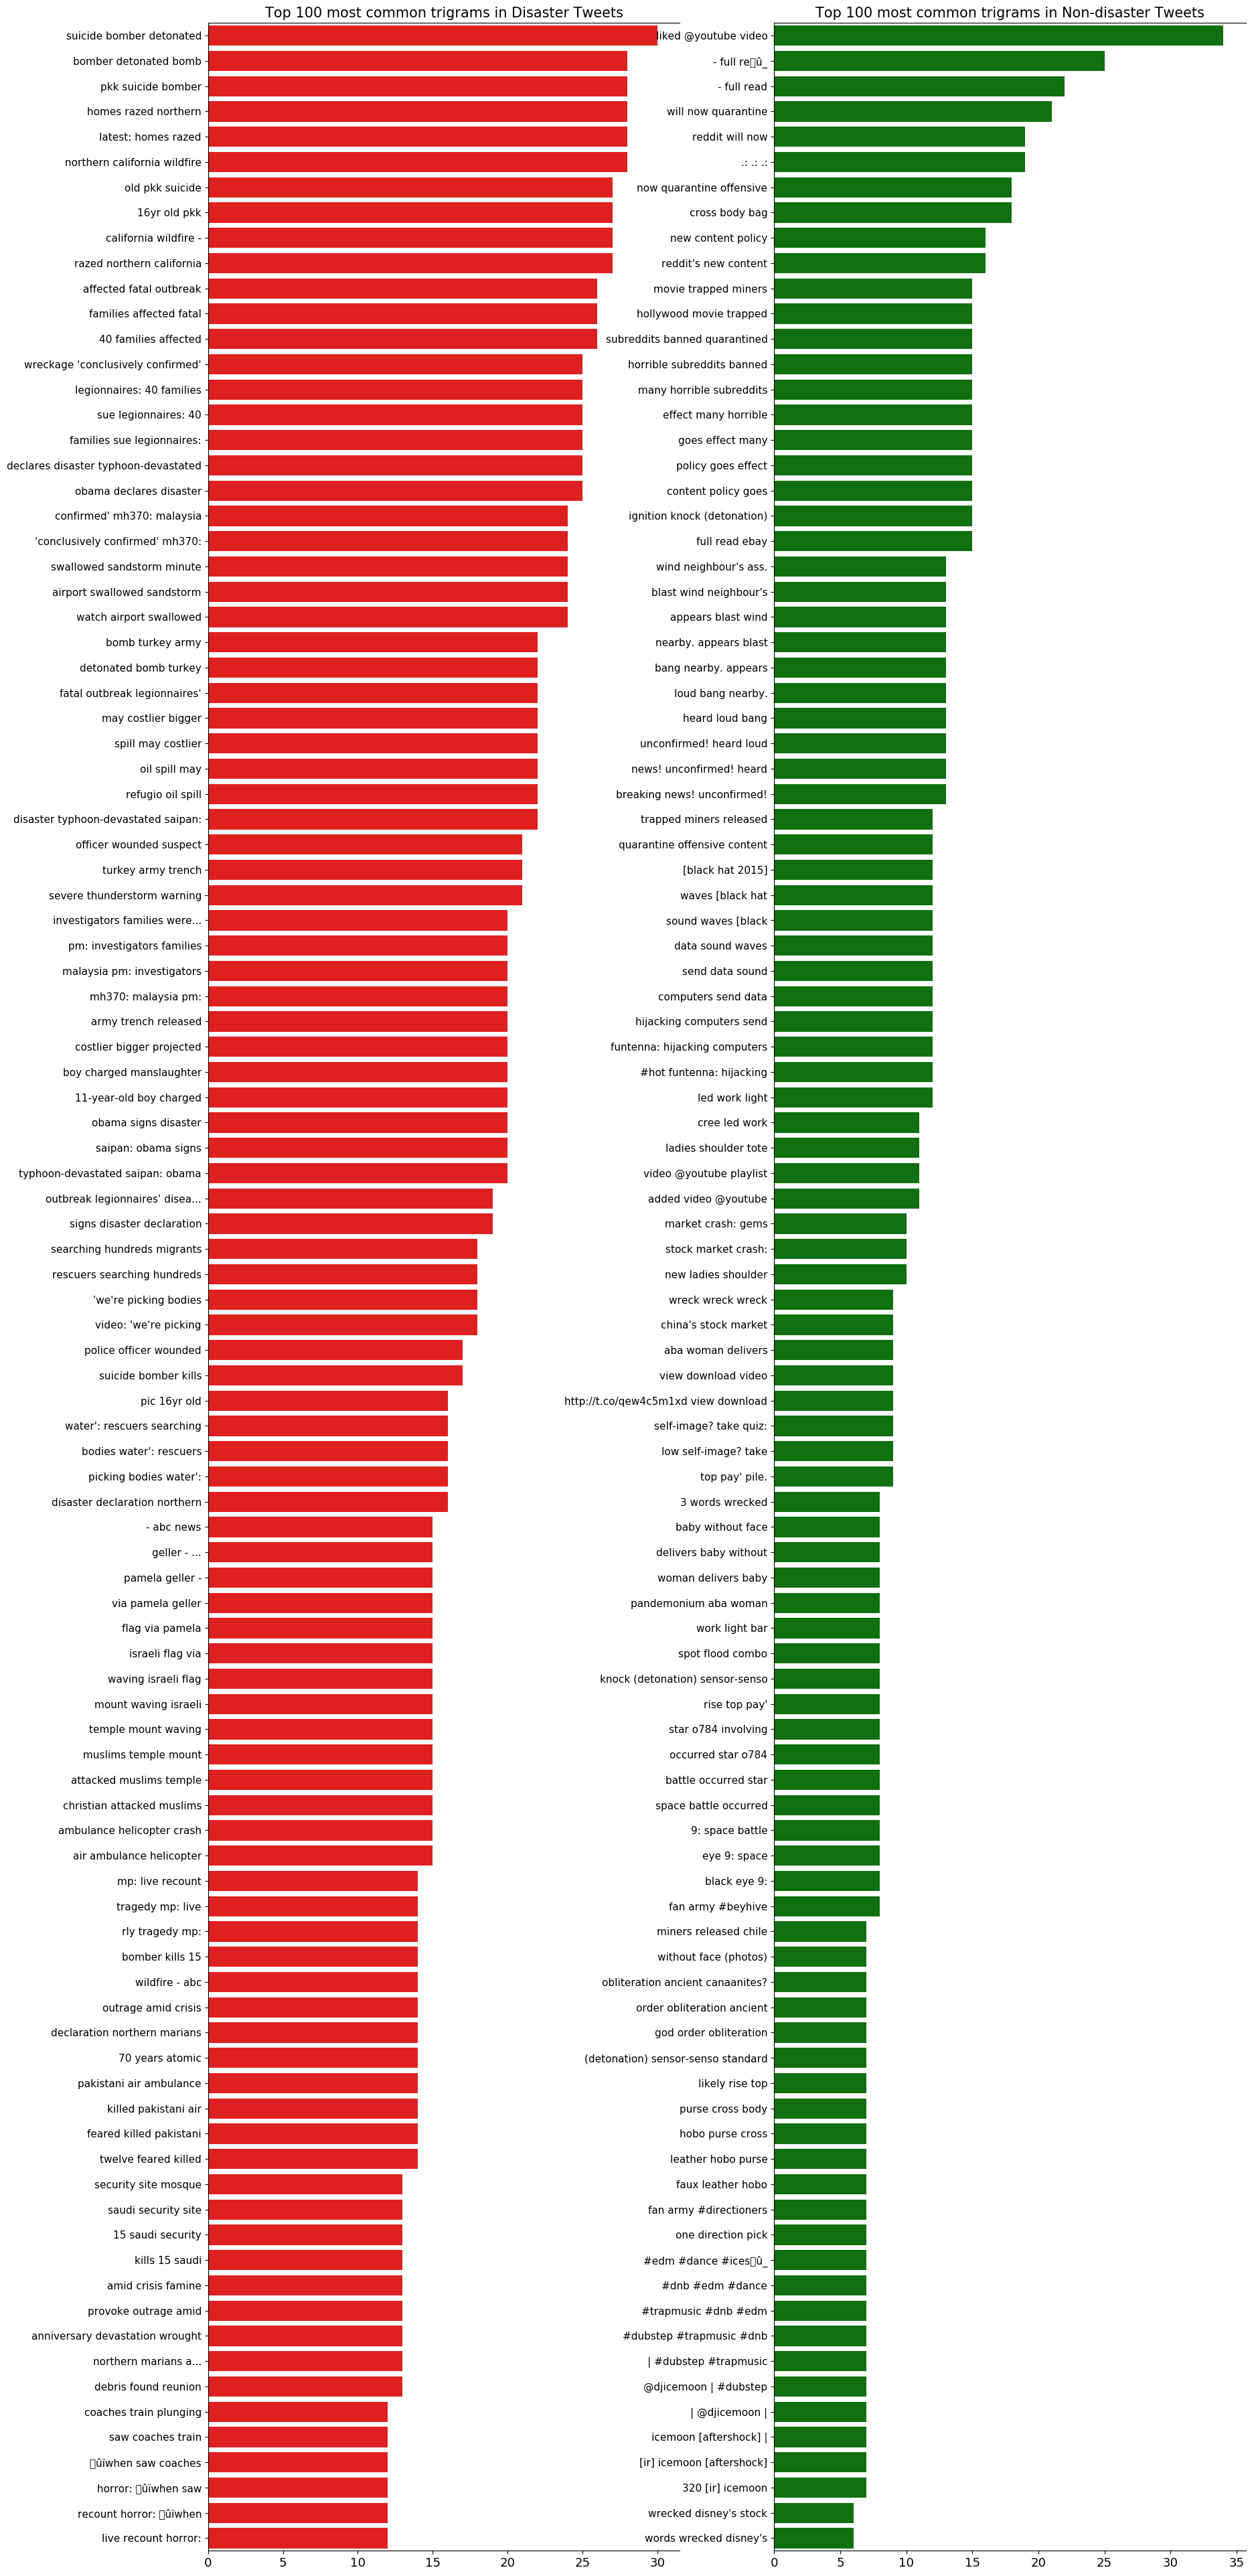

In [128]:
fig, axes = plt.subplots(1,2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)